In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, datasets
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from tqdm import tqdm



In [2]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# !unzip -qq captcha_images_v2.zip

In [3]:
data_dir = Path("/home/mohe/Documents/keras_examples/Data/class1")

images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split("*.png")[0] for img in images]
labels = [i[:-4] for i in labels]
chars = set(char for label in labels for char in label)
chars = sorted(list(chars))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(chars))
print("Characters present: ", chars)


batch_size = 16

img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

max_length = max([len(label) for label in labels])


Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [4]:
dir = "/home/mohe/Documents/keras_examples/Data/class1"

img_names = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
labels = [i[:-4] for i in img_names]
labels

['wg625',
 'px2xp',
 '4exnn',
 '6cm6m',
 'yg5bb',
 'fnbfw',
 '387g2',
 'cd4eg',
 '2cg58',
 'gng6e',
 '7cdge',
 'cfp86',
 '6n443',
 '32dnn',
 'd3c8y',
 'b84xc',
 '22d5n',
 'x7422',
 'c3n8x',
 'pcede',
 'x74b2',
 'pgm2e',
 'm6n4x',
 'b2nen',
 'x4gg5',
 'dyxnc',
 'mg5nn',
 'cnwyc',
 'mbp2y',
 'bf52c',
 '47m2b',
 'y2ye8',
 'b685n',
 '2mpnn',
 'ffd6p',
 'e72cd',
 '6fn84',
 'cdf77',
 'p8c24',
 '3x5fm',
 'fg7mg',
 'byfgn',
 '7gce6',
 '2w4y7',
 '43gey',
 'ef4mn',
 '6e6pn',
 'dy3cx',
 'px8n8',
 '2g783',
 'deep5',
 'x8xnp',
 'cpe63',
 'gbxyy',
 '2n73f',
 'n3bm6',
 '5wddw',
 'nbwnn',
 'myc3c',
 '33f7m',
 'x4f7g',
 '8n62n',
 'n7dyb',
 'cwdnx',
 '5yxgp',
 'yxd7m',
 'pg2pm',
 '56m6y',
 'n2gmg',
 'men4f',
 '823p2',
 'n7enn',
 'nmw46',
 'edg3p',
 '8y63f',
 'p2ym2',
 '646x8',
 '2nf26',
 '25egp',
 'ndg2b',
 'pmd3w',
 'c7gb3',
 'wyc25',
 'nd5wg',
 'ennmm',
 'd75b5',
 'myf82',
 'x6pdb',
 'x5nyn',
 '7p852',
 '85dxn',
 'ecd4w',
 'nf8b8',
 'mfb3x',
 'nbfx5',
 '2gyb6',
 '53wp3',
 'w52fn',
 'fc6xb',
 'f364x',


In [5]:
char_to_index = {char: idx for idx, char in enumerate(chars)}
index_to_char = {idx: char for idx, char in enumerate(chars)}

def encode(label):
    encoded_label = torch.tensor([char_to_index[char] for char in label])
    return encoded_label


def decode(encoded_label: torch.tensor):
    return "".join([index_to_char[idx.item()] for idx in encoded_label])


encode("ybfx6"), decode(encode("ybfx6"))

(tensor([18,  7, 11, 17,  4]), 'ybfx6')

In [6]:
class CAPTCHADataset(Dataset):
    def __init__(self, img_dir, transform=None, label_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.label_transform = label_transform
        self.img_names = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
        self.labels = [i[:-4] for i in img_names]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
        
        label = os.path.splitext(img_name)[0] # Extract label from filename without extension  
        label = encode(label)
        return image, label


In [23]:

image_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)), 
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Grayscale(),  
])
dataset = CAPTCHADataset("/home/mohe/Documents/keras_examples/Data/class1", transform = image_transforms)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


for img, label in train_loader:
    print((img.size(), label))
    break
   
    

(torch.Size([32, 1, 50, 200]), tensor([[ 5,  9, 12,  8,  0],
        [ 0,  2,  1, 13, 13],
        [ 1, 13, 17,  9, 14],
        [12,  0,  3,  5,  5],
        [ 9,  0,  0, 18,  3],
        [ 2, 14, 14, 11,  1],
        [11, 14,  7, 11, 16],
        [ 6,  6,  7, 12, 17],
        [11,  4, 14, 10,  3],
        [ 2,  0, 14, 17, 18],
        [14,  7, 16, 15, 14],
        [ 1,  6,  5, 12,  0],
        [ 9,  9, 13, 18, 12],
        [ 1,  1, 11,  5, 13],
        [17,  6, 17, 14, 15],
        [11,  8,  0, 11, 11],
        [ 0,  0,  9,  3, 14],
        [16, 13,  2,  5, 11],
        [13,  9,  1,  2,  2],
        [10,  9, 12,  1, 15],
        [ 4,  8, 16, 17, 10],
        [ 0,  0,  4, 13,  9],
        [ 1,  1, 14, 12,  2],
        [ 6,  7,  7, 13,  2],
        [10, 16,  8, 11,  3],
        [15,  6, 14, 12, 17],
        [ 2,  9,  0,  0, 13],
        [ 8,  9, 11,  5,  5],
        [ 3, 14, 12,  4, 10],
        [ 1,  1,  7,  0,  0],
        [12, 16,  2,  4,  6],
        [ 3, 11, 18, 10, 13]]))


In [82]:

def imshow(imgs, labels):
    imgs = imgs / 2 + 0.5  # Unnormalize
    labels = [decode(label) for label in labels]
    npimg = imgs.numpy()

    # Create a grid of images
    grid = torchvision.utils.make_grid(imgs, nrow=4, padding=2, pad_value=255)
    npgrid = grid.numpy()

    # Transpose the grid to match the expected dimensions for plt.imshow
    if npgrid.shape[0] == 1:  # Grayscale image
        npgrid = npgrid.squeeze(0)
    else:  # RGB image
        npgrid = np.transpose(npgrid, (1, 2, 0))

    # Display the grid
    plt.figure(figsize=(20, 10))
    plt.imshow(npgrid, cmap='gray')

    # Calculate the number of rows in the grid
    n_images = imgs.size(0)
    n_cols = 4
    n_rows = (n_images + n_cols - 1) // n_cols

    # Add labels below each image
    for i in range(n_images):
        col = i % n_cols
        row =i  // n_cols
        print(f'i: {i}, len(labels): {len(imgs)}')  # Debugging statement

        label = labels[i]
        plt.text(col * imgs.size(3) + imgs.size(3) // 2, (row + 1) * imgs.size(2) - 10, label, ha='right', fontsize=8, color='black', backgroundcolor='white')
    
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


torch.Size([32, 1, 50, 200]) torch.Size([32, 5])


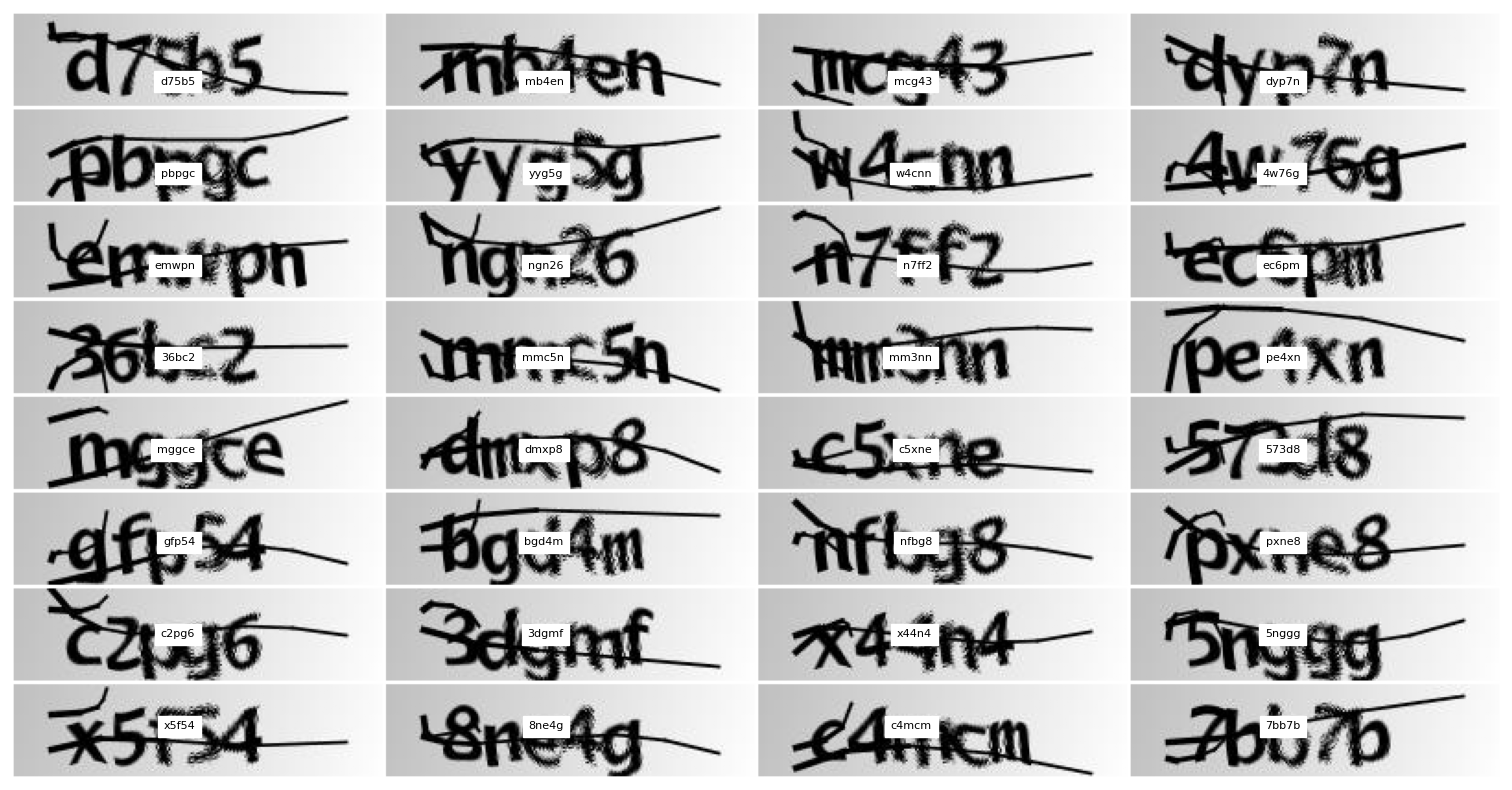

In [71]:

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.size(), labels.size())

imshow(images, labels)

In [18]:
len(chars)

19

# Model

In [64]:
class CAPTCHASolver(nn.Module):
    def __init__(self, img_height, img_width,  label_size = 5):
        super(CAPTCHASolver, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1)
        self.relu = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.new_height = img_height // 4
        self.new_width = img_width // 4
        self.linear = nn.Linear(self.new_height * self.new_width * 64, 64)
        self.relu = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        
        self.bilstm1 = nn.LSTM(64, 128, dropout=0.25, bidirectional=True, num_layers=2)
        self.bilstm2 = nn.LSTM(256, 64, dropout=0.25, bidirectional=True, num_layers=2)

        self.linear2 = nn.Linear(128, len(chars) + 1)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x) 
        x = self.pool2(x)
        
        batch_size = x.size(0)
        x = x.view(batch_size, -1)

        x = self.linear(x)
        x = F.relu(x)
        x = self.dout(x)
        x, _ = self.bilstm1(x.unsqueeze(1))
        x, _ = self.bilstm2(x)

        x = self.linear2(x)
        x = F.softmax(x)
        
        return x


In [115]:
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(m.bias)


model = CAPTCHASolver(img_height, img_width)
model.apply(weight_init)

CAPTCHASolver(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=38400, out_features=64, bias=True)
  (dout): Dropout(p=0.2, inplace=False)
  (bilstm1): LSTM(64, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (bilstm2): LSTM(256, 64, num_layers=2, dropout=0.25, bidirectional=True)
  (linear2): Linear(in_features=128, out_features=20, bias=True)
  (softmax): Softmax(dim=None)
)

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

EPOCHS = 100
early_stopping_patience = 10
best_val_loss = float('inf')
current_patience = 0

crietrion = nn.CTCLoss(blank= len(chars))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        outputs = model(imgs)
        outputs = outputs.permute(1, 0, 2)
        log_probs = torch.log(outputs)  # Convert softmax output to log probabilities

        input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(0), dtype=torch.long).to(device)
        target_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long).to(device)
        loss = crietrion(log_probs, labels, input_lengths, target_lengths)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    # model.eval()
    # val_loss = 0
    # with torch.no_grad():
    #     for val_imgs, val_labels in val_loader:
    #         val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
    #         val_outputs = model(val_imgs)
    #         val_outputs = val_outputs.permute(1, 0, 2)
    #         val_log_probs = torch.log(val_outputs)
    #         val_input_lengths = torch.full(size=(val_imgs.size(0),), fill_value=val_outputs.size(0), dtype=torch.long).to(device)
    #         val_target_lengths = torch.tensor([len(label) for label in val_labels], dtype=torch.long).to(device)
    #         val_loss += crietrion(val_log_probs, val_labels, val_input_lengths, val_target_lengths).item()

    # avg_train_loss = epoch_loss / len(train_loader)
    # avg_val_loss = val_loss / len(val_loader)
    # print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # if avg_val_loss < best_val_loss:
    #     best_val_loss = avg_val_loss
    #     current_patience = 0
    # else:
    #     current_patience += 1
    #     if current_patience >= early_stopping_patience:
    #         print("Early stopping triggered.")


    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss}")
    # if epoch % 10 == 5:
        # imshow(imgs.cpu(), [decode(output.cpu()[:6]) for output in outputs.squeeze(0)])


  0%|          | 0/26 [00:00<?, ?it/s]

/tmp/ipykernel_143811/1692481589.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
100%|██████████| 26/26 [00:00<00:00, 73.75it/s]


Epoch 1/100, Loss: inf


100%|██████████| 26/26 [00:00<00:00, 73.95it/s]


Epoch 2/100, Loss: inf


100%|██████████| 26/26 [00:00<00:00, 67.22it/s]


Epoch 3/100, Loss: inf


100%|██████████| 26/26 [00:00<00:00, 68.34it/s]


Epoch 4/100, Loss: inf


100%|██████████| 26/26 [00:00<00:00, 68.29it/s]


Epoch 5/100, Loss: inf


100%|██████████| 26/26 [00:00<00:00, 68.33it/s]


Epoch 6/100, Loss: inf


100%|██████████| 26/26 [00:00<00:00, 67.13it/s]


Epoch 7/100, Loss: inf


 69%|██████▉   | 18/26 [00:00<00:00, 66.40it/s]


KeyboardInterrupt: 